# Deep Learning and Its Applications to Signal and Image Processing and Analysis - Assignment 3


## Introduction
In this assignment, you will perform an image classification task on the CIFAR-10 dataset using two
model families: Convolutional Neural Networks (CNNs) and Vision Transformers (ViTs). The objectives
are to develop models, apply explainability tools (Grad-CAM and attention visualization), and evaluate
comparative performance using confusion matrices and other metrics. In this assignment, you will also
learn how to use the pytorch-lightning library. This library simplifies model building and training, and
it also supports automatic logging to Weights & Biases. There is a complementary notebook attached
to the assignment. A complementary notebook is provided with this assignment. It is intended for your
convenience, and you are free to modify it as needed.

### Imports and mount drive - in this notebook i will work on my own pc. so do not need to use colab syntax

In [1]:
from typing import Any

import numpy as np
# skip this
# !pip install pytorch-lightning
# skip that
# 📦 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Subset

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

import wandb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 🧹 Set seeds and configs
pl.seed_everything(42)

Seed set to 42


42

In [ ]:
# skip this
# from google.colab import drive
# drive.mount('/content/drive')
# skip that

In [ ]:
import os
# os.chdir('')

## 1. CNN Classification and Grad-CAM Explainability

In this section, you will implement a CNN from scratch and apply Grad-CAM to explain the model predictions.

###  1.1. Load and Preprocess CIFAR-10

a. load dataset:

In [2]:
# Define a transform to normalize the data
# Widely‑used baseline
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

# Source for values: https://github.com/kuangliu/pytorch-cifar/issues/19
# Source2 for values: https://stackoverflow.com/questions/69747119/pytorch-cifar10-images-are-not-normalized

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

#⬇️ Load dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


a.plot sample images:

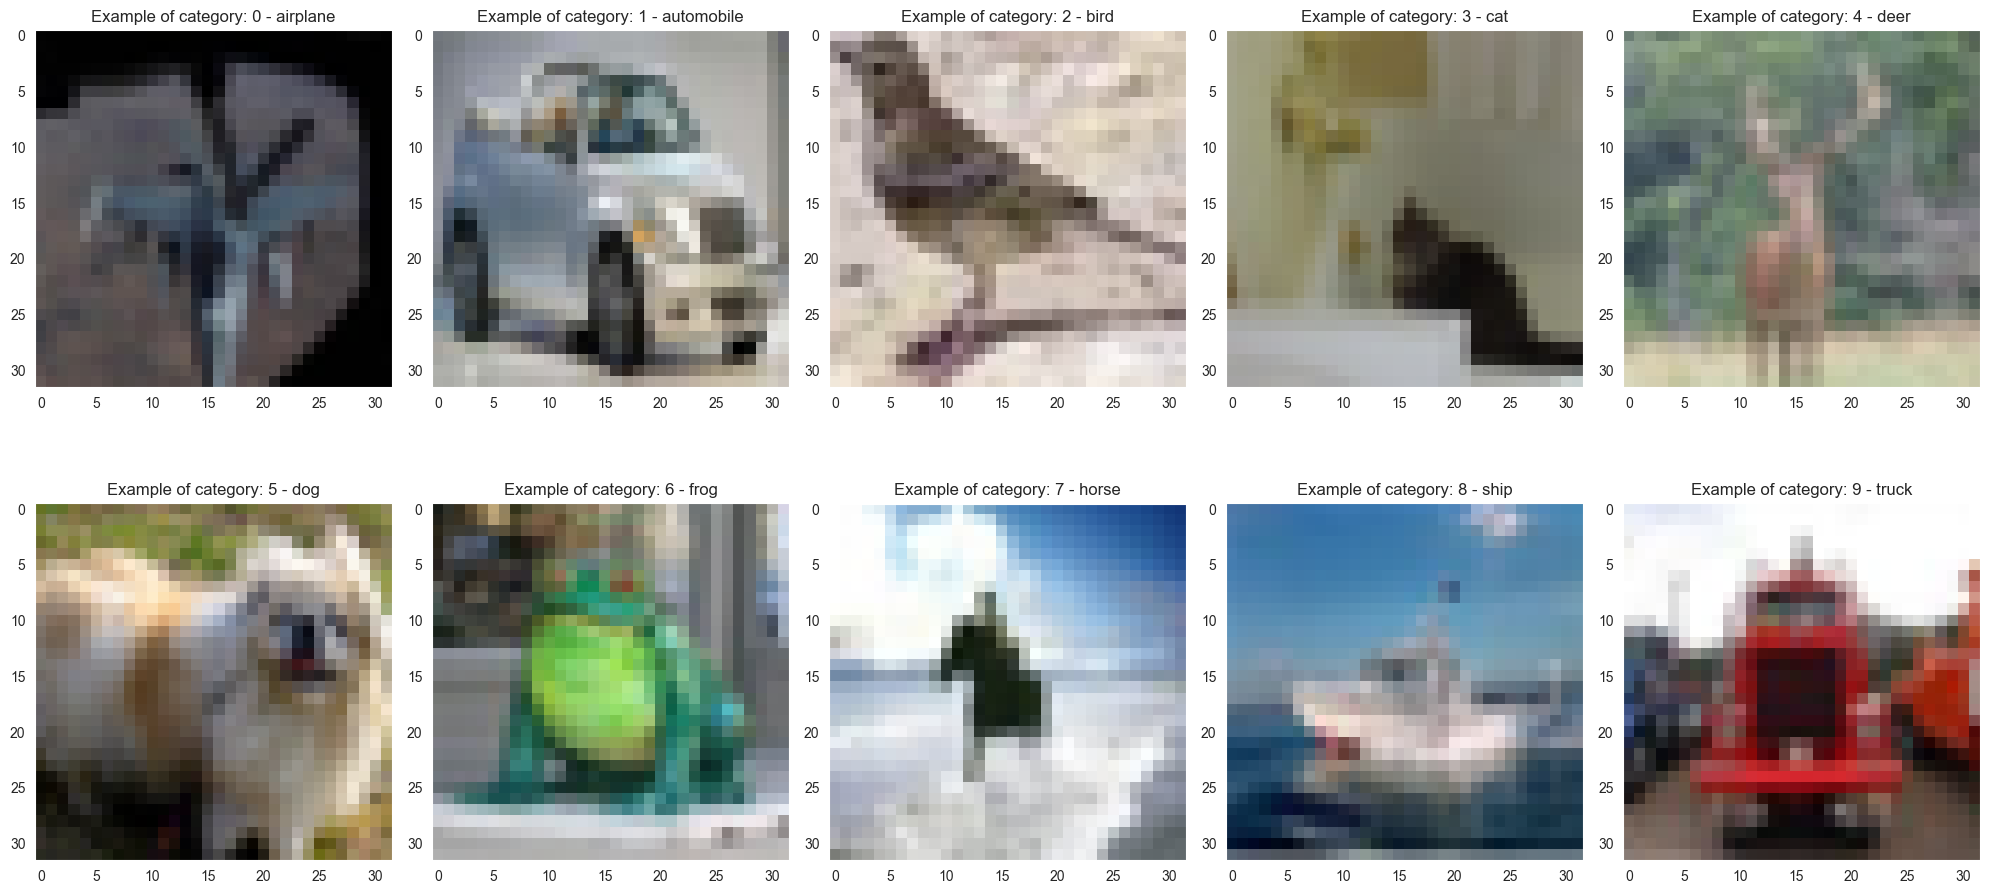

In [3]:
import random
import numpy as np
def get_class_name_from_idx(dictionary,idx):
    for key, value in dictionary.items():
        if value == idx:
            return key
def show_example_per_label(dataset):
    sample_targets = []
    sample_indices = []
    random.seed(234)
    for k,target in enumerate(dataset.targets):
        if random.random() < 0.05: # get different images every time
            if not target in sample_targets:
                sample_indices.append(k)
                sample_targets.append(target)
    sorted_indices_by_target = np.argsort(sample_targets)

    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

    row = 0
    index = 0
    switchbool= False
    for k in sorted_indices_by_target:
        axs[row,index]. grid(False)
        axs[row,index].set_title(f"Example of category: {sample_targets[k]} - {get_class_name_from_idx(dataset.class_to_idx,sample_targets[k])}")
        axs[row,index].imshow(dataset.data[sample_indices[k]])
        index+=1
        if index > 4 and switchbool== False:
            switchbool = True
            row = 1
            index = 0
    fig.tight_layout()
    plt.show()
show_example_per_label(dataset)

b. split - 30k train, 20k valid, 10k test (50,33.33,16.66)

In [4]:
from sklearn.model_selection import train_test_split
targets = dataset.targets

train_idx, valid_idx= train_test_split(
    np.arange(len(targets)), test_size=0.4, random_state=42, shuffle=True, stratify=targets)

train_dataset = Subset(dataset, train_idx)
validation_dataset = Subset(dataset, valid_idx)

print("Train dataset:" + str(len(train_dataset)))
print("Validation dataset:" + str(len(validation_dataset)))
print("Test dataset:" + str(len(test_dataset)))


Train dataset:30000
Validation dataset:20000
Test dataset:10000


c. preview categories histogram in each dataset

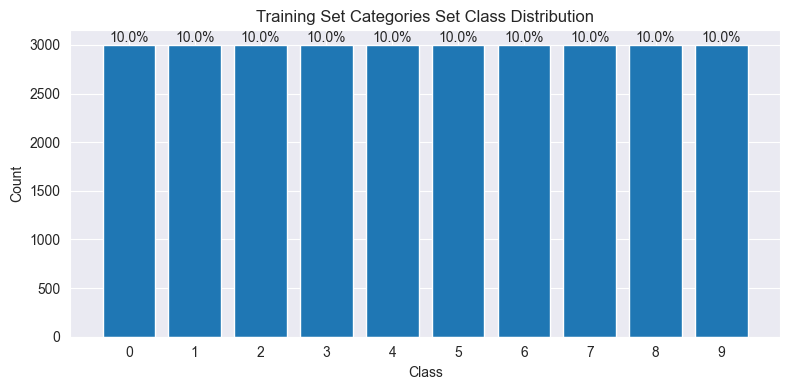

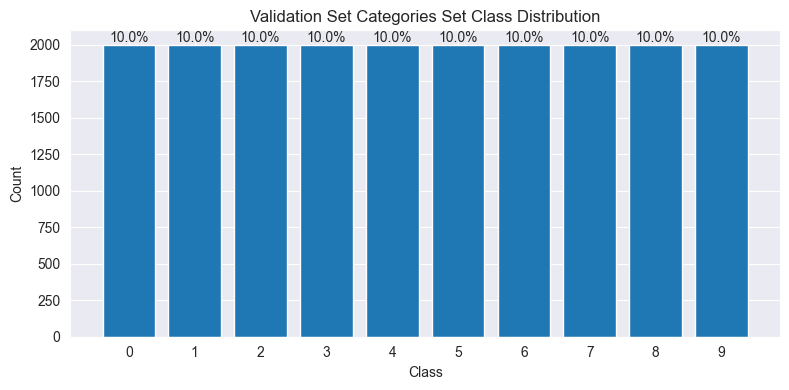

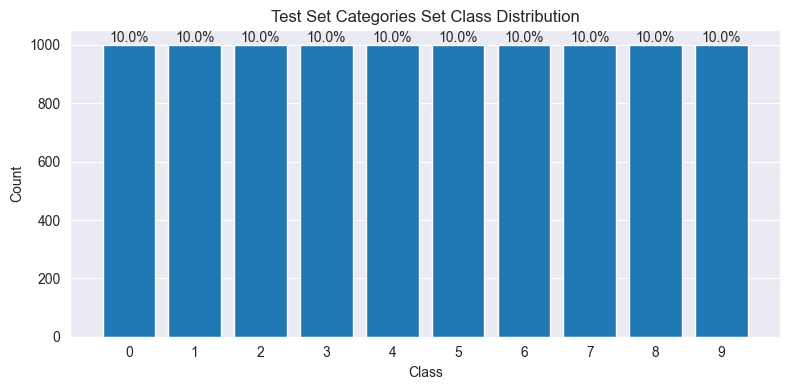

In [5]:
def plot_categories_histograms(set,header):
    # Extract class labels from the original dataset (Subset stores indices)
    # Supports subset or full dataset via try except mechanism on input
    try:
        labels = [set.dataset.targets[i] for i in set.indices]
    except:
        labels = [set.targets[i] for i in range(len(set.targets))]
    # Creating histogram dicts:
    counting_dict={}
    for k in range(10):
        counting_dict[k]=0
    # Count occurrences of each class
    for i,value in enumerate(np.array(labels)):
        counting_dict[value] +=1

    # Extract class indices and corresponding counts
    classes = list(counting_dict.keys())
    counts = [counting_dict[k] for k in classes]

    total = sum(counts)
    percentages = [count / total * 100 for count in counts]

    # Plotting training set histogram
    plt.figure(figsize=(8, 4))
    bars = plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'{header} Set Class Distribution')
    plt.xticks(classes)
    plt.tight_layout()

    # Add percentage labels on top of bars
    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height , f'{percent:.1f}%',
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_categories_histograms(train_dataset, 'Training Set Categories')
plot_categories_histograms(validation_dataset, 'Validation Set Categories')
plot_categories_histograms(test_dataset, 'Test Set Categories')

###  1.2. Define CNN in PyTorch Lightning

a.

In [20]:
import torchmetrics

class SimpleCNN(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr
        self.loss = nn.CrossEntropyLoss()

        self.train_acc = torchmetrics.Accuracy(task="multiclass",
                                               num_classes=10)
        self.val_acc   = torchmetrics.Accuracy(task="multiclass",
                                               num_classes=10)
        self.test_acc  = torchmetrics.Accuracy(task="multiclass",
                                               num_classes=10)

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                padding=1)
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                                padding=1)
        self.linear_1 = nn.Linear(4096, 300)
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(300, 10)

    def forward(self, x):
        x = self.relu_1(self.conv_1(x)) # in: 3x32X32, out: 16x32X32
        x = self.relu_1(self.conv_2(x)) # in: 16x32X32, out: 32x32X32
        x = self.mp(x) # in: 32X32X32, out: 32X16X16
        x = self.relu_1(self.conv_3(x)) # in: 32X16X16, out: 64x16X16
        x = self.mp(x) # in: 64x16X16, out: 64x8X8
        x = x.reshape(x.size(0), -1) # 64x8x8 = 4096
        x = self.relu_1(self.linear_1(x)) # input 4096, output: 300
        x = self.linear_2(x) # input 300, output: 3
        return x

    def training_step(self, batch, batch_idx):
        loss, preds, y = self.common_step(batch, batch_idx)
        self.train_acc.update(preds,y)
        self.log("train_acc",self.train_acc,
                 on_step=False,on_epoch=True,prog_bar=True)
        self.log('train loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y = self.common_step(batch, batch_idx)
        self.val_acc.update(preds,y)
        self.log("val_acc",self.val_acc,
                 on_step=False,on_epoch=True,prog_bar=True)
        self.log('validation loss', loss, prog_bar=True)
        return loss


    def test_step(self, batch, batch_idx):
        loss, preds, y = self.common_step(batch, batch_idx)
        self.test_acc.update(preds,y)
        self.log("test_acc",self.test_acc,
                 on_step=False,on_epoch=True,prog_bar=True)
        self.log('test loss', loss, prog_bar=True)
        return loss

    def common_step(self, batch, batch_idx):
        x,y = batch
        scores = self.forward(x)
        loss = self.loss(scores, y)
        return loss, scores, y

    def predict_step(self,batch,batch_idx):
        x,y = batch
        scores = self.forward(x)
        preds = torch.argmax(scores, dim=1)
        return preds

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [24]:
from pytorch_lightning.callbacks import EarlyStopping

BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = SimpleCNN()

early_stop = EarlyStopping(monitor="validation loss",mode="min", patience=5, verbose=True)
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="validation loss", mode="min",verbose=True)


trainer = pl.Trainer(accelerator="gpu",devices=[0],min_epochs=5,max_epochs=25,callbacks=[early_stop,checkpoint_callback])
trainer.fit(model,train_loader,validation_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | loss      | CrossEntropyLoss   | 0      | train
1  | train_acc | MulticlassAccuracy | 0      | train
2  | val_acc   | MulticlassAccuracy | 0      | train
3  | test_acc  | MulticlassAccuracy | 0      | train
4  | conv_1    | Conv2d             | 448    | train
5  | conv_2    | Conv2d             | 4.6 K  | train
6  | mp        | MaxPool2d          | 0      | train
7  | conv_3    | Conv2d             | 18.5 K | train
8  | linear_1  | Linear             | 1.2 M  | train
9  | relu_1    | ReLU               | 0      | train
10 | linear_2  | Linear             | 3.0 K  | train
----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.023 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved. New best score: 1.216
Epoch 0, global step 235: 'validation loss' reached 1.21551 (best 1.21551), saving model to 'C:\\Users\\ndvam\\PycharmProjects\\deeplearning_hw3\\lightning_logs\\version_36\\checkpoints\\epoch=0-step=235.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved by 0.189 >= min_delta = 0.0. New best score: 1.026
Epoch 1, global step 470: 'validation loss' reached 1.02618 (best 1.02618), saving model to 'C:\\Users\\ndvam\\PycharmProjects\\deeplearning_hw3\\lightning_logs\\version_36\\checkpoints\\epoch=1-step=470.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved by 0.077 >= min_delta = 0.0. New best score: 0.949
Epoch 2, global step 705: 'validation loss' reached 0.94920 (best 0.94920), saving model to 'C:\\Users\\ndvam\\PycharmProjects\\deeplearning_hw3\\lightning_logs\\version_36\\checkpoints\\epoch=2-step=705.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved by 0.073 >= min_delta = 0.0. New best score: 0.876
Epoch 3, global step 940: 'validation loss' reached 0.87591 (best 0.87591), saving model to 'C:\\Users\\ndvam\\PycharmProjects\\deeplearning_hw3\\lightning_logs\\version_36\\checkpoints\\epoch=3-step=940.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved by 0.005 >= min_delta = 0.0. New best score: 0.871
Epoch 4, global step 1175: 'validation loss' reached 0.87135 (best 0.87135), saving model to 'C:\\Users\\ndvam\\PycharmProjects\\deeplearning_hw3\\lightning_logs\\version_36\\checkpoints\\epoch=4-step=1175.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1410: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1645: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1880: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 2115: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric validation loss did not improve in the last 5 records. Best score: 0.871. Signaling Trainer to stop.
Epoch 9, global step 2350: 'validation loss' was not in top 1


In [25]:
best_model = SimpleCNN.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.validate(model=best_model,dataloaders=validation_loader)
trainer.test(model=best_model,dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7015500068664551     │
│      validation loss      │    0.8713467717170715     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test loss         │    0.8728660941123962     │
│         test_acc          │    0.7026000022888184     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7026000022888184, 'test loss': 0.8728660941123962}]

b. Your model should achieve an accuracy of at least 0.80 on the training set, and at least 0.70 on both the validation and test sets.

In [ ]:
# 🪄 Init wandb logger
wandb_logger = WandbLogger(project="CNN-CIFAR10", log_model=True)

# ⚡ Instantiate model and trainer
model = SimpleCNN(lr=...)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    #raise NotImplementedError("TODO: Implement this part")

)

trainer = pl.Trainer(
    #raise NotImplementedError("TODO: Implement this part")
)

# 🏋️‍♂️ Train
trainer.fit(model, train_loader, val_loader)

c.

In [ ]:
# 🔍 Evaluate
trainer.test(model, dataloaders=test_loader)

#Show F1 score and confusion matrix you can do it in def on_test_epoch_end(self): and log it to wandb

# 💾 Save the model in thr last epoch if saved by metric  
torch.save(model.state_dict(), "cnn_cifar10_checkpoint.ckpt")

## 1.3 Explainability with Grad-CAM

a.

In [ ]:
!pip install grad-cam --quiet

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Define the target layer for Grad-CAM (adjust if needed)
target_layer = ... # raise NotImplementedError("TODO: Implement this part")

cam = GradCAM(model=model, target_layers=[target_layer])


generate Grad-CAM heatmaps for several test images

In [ ]:
# generate Grad-CAM heatmaps for several test image

## 2. Vision Transformer (ViT) and Attention Visualization


In this section, you will implement a Vision Transformer (ViT) from scratch and compare it to the CNN
model developed in Section 1. Additionally, you will visualize attention maps to gain insight into the
model’s decision process.

### 2.1 Implementing the Vision Transformer

a.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=..., patch_size=..., emb_size=..., img_size=...):
      raise NotImplementedError("TODO: Implement this part")

    def forward(self, x):
      raise NotImplementedError("TODO: Implement this part")

class ViTWithAttention(nn.Module):
  def __init__(self, img_size=..., patch_size=..., in_channels=..., num_classes=...,):
    raise NotImplementedError("TODO: Implement this part")

  def forward(self, x):
    raise NotImplementedError("TODO: Implement this part")

class ViTLightningModule(pl.LightningModule):
  def __init__(self, lr=...):
    raise NotImplementedError("TODO: Implement this part")

  def forward(self, x):
    raise NotImplementedError("TODO: Implement this part")

  def training_step(self, batch, batch_idx):
    raise NotImplementedError("TODO: Implement this part")

  def validation_step(self, batch, batch_idx):
    raise NotImplementedError("TODO: Implement this part")
  
  def test_step(self, batch, batch_idx):
    raise NotImplementedError("TODO: Implement this part")

  def configure_optimizers(self):
    raise NotImplementedError("TODO: Implement this part")

b. Your model should achieve an accuracy of at least 0.70 on the training set, and at least 0.60 on both the validation and test sets.

In [ ]:
# 🪄 Init wandb logger
wandb_logger = WandbLogger(project="ViT-CIFAR10", log_model=True)

# ⚡ Instantiate model and trainer
model = ViTLightningModule(lr=...)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    # raise NotImplementedError("TODO: Implement this part")
)

trainer = pl.Trainer(
    # raise NotImplementedError("TODO: Implement this part")
)

# 🏋️‍♂️ Train
trainer.fit(model, train_loader, val_loader)

c.

In [ ]:
# 🔍 Evaluate
trainer.test(model, dataloaders=test_loader)

#Show F1 score and confusion matrix you can do it in def on_test_epoch_end(self): and log it to wandb

### 2.2 Visualizing Attention Maps

In [ ]:
def visualize_attention(model, image_tensor, patch_size=4):
    raise NotImplementedError("TODO: Implement this part")
